Model creation and evaluation

--Module and data imports

In [117]:
import import_data_module
import data_cleaner_module
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

data = import_data_module.import_dataframe_from_csv("../model_data/CrabAgePrediction.csv")
data_cleaned = data_cleaner_module.clean_Data(data)

data_cleaned.reset_index(drop=True, inplace=True)

Data standardization

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = data_cleaned.select_dtypes(include=['float', 'int']).drop(columns="Age").columns

scaled_data = scaler.fit_transform(data_cleaned[cols_to_scale])

scaled_dataframe = pd.DataFrame(scaled_data, columns=cols_to_scale)

scaled_dataframe = pd.concat([scaled_dataframe, data_cleaned.drop(columns=cols_to_scale)], axis=1)


Data encoding

In [119]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

cols_to_encode = data_cleaned.select_dtypes(include=['object']).columns

encoded_data = label_encoder.fit_transform(data_cleaned[cols_to_encode[0]].values)

encoded_dataframe = pd.DataFrame(encoded_data, columns=cols_to_encode)

prepared_dataframe = pd.concat([encoded_dataframe, scaled_dataframe.drop(columns=cols_to_encode)], axis=1)

Linear Regression Ridge

-- Data split and feature selection

In [144]:
print(prepared_dataframe.columns)

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')


In [145]:
feature = prepared_dataframe.drop(columns=['Age'])
target = prepared_dataframe["Age"]

feature["Volume"] = feature["Length"] * feature["Height"] * feature["Diameter"]
feature["Weight proportion"] = (feature["Shucked Weight"] + feature["Viscera Weight"] + feature["Shell Weight"]) / feature["Weight"]
feature["Shucked proportion"] = feature["Shucked Weight"] / feature["Weight"]
feature["Viscera proportion"] = feature["Viscera Weight"] / feature["Weight"]
feature["Shell proportion"] = feature["Shell Weight"] / feature["Weight"]

X_train, X_test, y_train, y_test =  train_test_split(feature, target, test_size=0.35, random_state=0)

--model

In [146]:
from sklearn.linear_model import Ridge

linear_model = Ridge(alpha=3.0753460654447227)

linear_model.fit(X_train, y_train)

print("Intercept: ", linear_model.intercept_)
print("Coefficients: ", linear_model.coef_)

linear_predictions = linear_model.predict(X_test)

Intercept:  9.92144784681618
Coefficients:  [ 0.05989973 -0.35996052  1.0000378   0.74158299  3.716801   -3.80308978
 -0.91881728  1.23547155  0.06549233 -0.01360463 -0.00903024 -0.00880893
  0.00423454]


Linear Evaluation

Mae: 1.5409089138174148
 Mse: 4.6364828913902025 
 RMSE: 2.153249379749174 
 R2: 0.5478319057618313


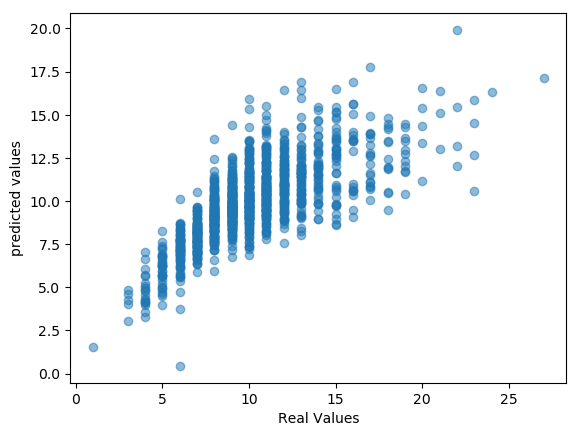

In [147]:
ridge_mae = mean_absolute_error(y_test, linear_predictions)
ridge_mse = mean_squared_error(y_test, linear_predictions)
ridge_r2 = r2_score(y_test, linear_predictions)

print(f"Mae: {ridge_mae}\n Mse: {ridge_mse} \n RMSE: {math.sqrt(ridge_mse)} \n R2: {ridge_r2}")

plt.scatter(y_test, linear_predictions, alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.show()

Linear cv

In [141]:
linear_cv = cross_val_score(linear_model, feature, target, cv=5)

print(f"Scores: {linear_cv}\n Mean: {linear_cv.mean()}\n Devation: {linear_cv.std()}")

Scores: [0.47430233 0.54822962 0.52014584 0.48436441 0.58148178]
 Mean: 0.5217047945983488
 Devation: 0.03980096229697775


Linear random search for hyperparams

In [142]:
params = {
    'alpha': uniform(0.1, 10), 
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

linear_search = RandomizedSearchCV(linear_model, param_distributions=params, n_iter=4, cv=5, random_state=0, error_score='raise')

linear_search.fit(X_train, y_train)

print(f"Best params: {linear_search.best_estimator_}")

Best params: Ridge(alpha=3.0753460654447227)


-----------------------------------------------------------------------------------------------------------------------------------------------------

Random forest

-- data selection and feature making

In [92]:
print(prepared_dataframe.columns)

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')


In [166]:
feature = prepared_dataframe.drop(columns=['Age'])
target = prepared_dataframe["Age"]

feature["Volume"] = feature["Length"] * feature["Height"] * feature["Diameter"]
feature["Weight proportion"] = (feature["Shucked Weight"] + feature["Viscera Weight"] + feature["Shell Weight"]) / feature["Weight"]
feature["Shucked proportion"] = feature["Shucked Weight"] / feature["Weight"]
feature["Viscera proportion"] = feature["Viscera Weight"] / feature["Weight"]
feature["Shell proportion"] = feature["Shell Weight"] / feature["Weight"]
feature["Shell area"] = (feature["Diameter"] / 2)**2 * math.pi

X_train, X_test, y_train, y_test =  train_test_split(feature, target, test_size=0.35, random_state=42)

--model

In [171]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=6, max_features=None, n_estimators=496)

rf_model.fit(X_train, y_train)

rf_predict = rf_model.predict(X_test)

Random forest evaluation

Mae: 1.5292732880705908
 Mse: 4.502323183043428 
 RMSE: 2.121867852398784 
 R2: 0.5638401564405695


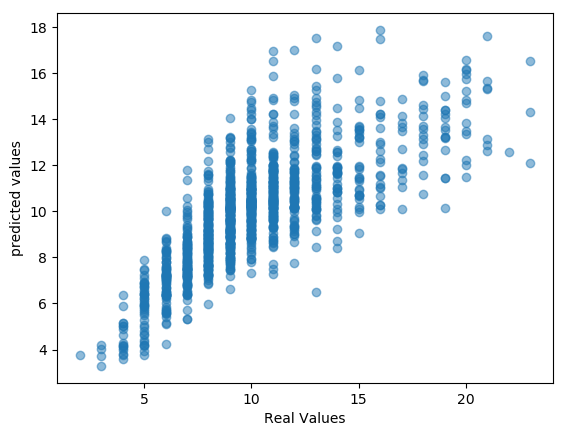

In [172]:
rf_mae = mean_absolute_error(y_test, rf_predict)
rf_mse = mean_squared_error(y_test, rf_predict)
rf_r2 = r2_score(y_test, rf_predict)

print(f"Mae: {rf_mae}\n Mse: {rf_mse} \n RMSE: {math.sqrt(rf_mse)} \n R2: {rf_r2}")

plt.scatter(y_test, rf_predict, alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.show()

Random forest cross validation

In [173]:
rf_scores = cross_val_score(rf_model, feature, target, cv=5)

print(f"Scores: {rf_scores}\n Mean: {rf_scores.mean()}\n Devation: {rf_scores.std()}")

Scores: [0.5558622  0.57110953 0.52126243 0.52683637 0.62675684]
 Mean: 0.5603654746704092
 Devation: 0.03793883663078563


Random forest hyperparameters random search

In [170]:
params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(2, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=8, cv=6, random_state=0, error_score='raise')

rf_search.fit(X_train, y_train)

print(f"Best params: {rf_search.best_estimator_}")

Best params: RandomForestRegressor(max_depth=6, max_features=None, n_estimators=496)


------------------------

Model comparison

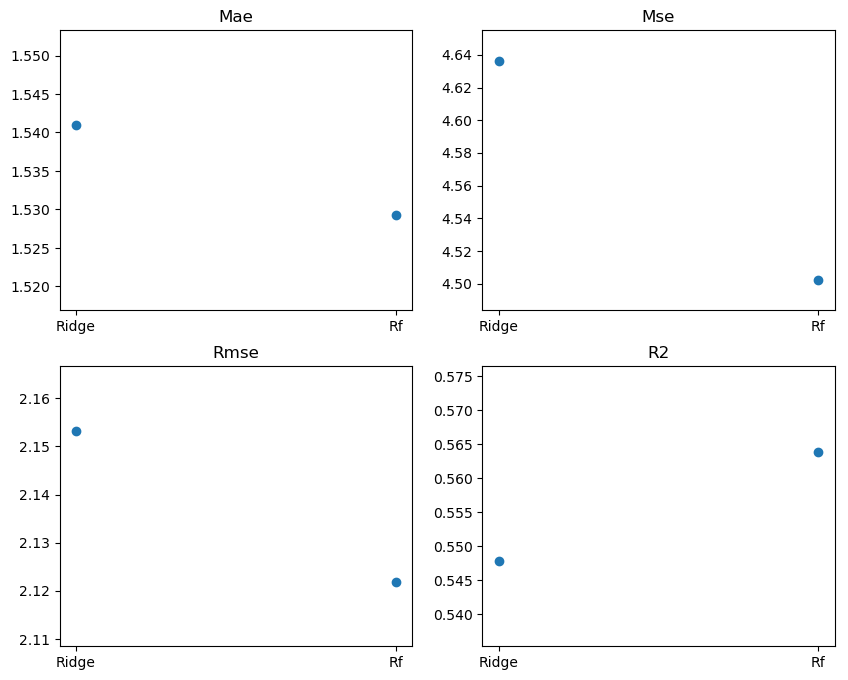

In [174]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].scatter(['Ridge', 'Rf'], [ridge_mae, rf_mae])
axs[0, 0].set_title('Mae')

axs[0, 1].scatter(['Ridge', 'Rf'], [ridge_mse, rf_mse])
axs[0, 1].set_title('Mse')

axs[1, 0].scatter(['Ridge', 'Rf'], [math.sqrt(ridge_mse), math.sqrt(rf_mse)])
axs[1, 0].set_title('Rmse')

axs[1, 1].scatter(['Ridge', 'Rf'], [ridge_r2, rf_r2])
axs[1, 1].set_title('R2')

plt.show()
